<a href="https://colab.research.google.com/github/zd2011/causal201/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 - Recitation - Matching and weighting

author: Judith Abécassis and Élise Dumas
with some inspiration from [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)

In today's recitation, we will implement the KNN-matching estimator with bias correction for one neighbor, to better understand how it works (exercise 1), and then compare matching and weighting on real data from the NSW job training program

## Exercise 1: implement matching
### question 1: to have a dataset to test things on, let's re-use the simulation of the lecture example

In [ ]:
pip install causalinference

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 6.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
import scipy.stats as sps
from sklearn.neighbors import KNeighborsRegressor
from causalinference import CausalModel
from sklearn.pipeline import make_pipeline


sns.set_context('poster')

In [ ]:
# Our sample size is
n = 3000

rg = np.random.default_rng(2907)
### 4 variables - Z - that are normal (0,1)
data_sim = pd.DataFrame(rg.normal(size=(n, 4)),
                        columns=['z{}'.format(i) for i in range(1, 5)])

### Outcome is a function of these + error
data_sim = data_sim.assign(Y=210 + 27.4*data_sim.z1 + 13.7*data_sim.z2 +
                           13.7*data_sim.z3 + 13.7*data_sim.z4 + rg.normal(size=n))

### True Propensity score is also a function of these
data_sim = data_sim.assign(omega= -1.5 -data_sim.z1 + .5*data_sim.z2 - .25*data_sim.z3 - .1*data_sim.z4)

# Convert to a probability
data_sim = data_sim.assign(pi=1/(1 + np.exp(-data_sim.omega)))

### Generate treatment based on the propensity scores
data_sim = data_sim.assign(T=rg.binomial(1, data_sim.pi, size=n))
data_sim.head()

,z1,z2,z3,z4,Y,omega,pi,T
0,1.098930,0.445812,-0.202055,1.942798,269.621397,-2.519790,0.074482,0
1,-0.509752,-0.751995,0.293914,0.549660,196.330663,-1.494690,0.183219,0
2,0.772191,0.507017,0.544381,1.549491,267.409865,-2.309727,0.090321,0
3,0.603948,0.464787,-1.325442,0.926284,228.611780,-1.632822,0.163444,0
4,-0.271929,-1.497915,-0.436955,-0.695071,167.065733,-1.798282,0.142060,0


### Question 2
#### question 2.1: implement KNN matching with k=1 (complete the following function draft.)

We will use the `KNeighborsRegressor` implementation from scikit-learn. Check the documentation to use it properly.

We are also going to use the neat trick that 
$$
  \widehat{ATE} = \frac{1}{n} \sum_{i=1}^n (2T_i -1) (Y_i - Y_{jm}(i))
$$

where $Y_{jm}(i)$ is the matched unit outcome from the other sample group.

In [ ]:
def matching(df, treatment, covariates, outcome):
    """
    implementation of the knn matching
    df: dataframe with the data
    treatment: str
               name of the variable for the treatment
    covariates: list
                list of covariate names
    outcome: str
             name of the outcome variable
    """
    # create two dataframes corresponding to the treated and untreated units
    treated = df.query("{}==1".format(treatment))
    untreated = df.query("{}==0".format(treatment))

    # create and fit two KNeighborsRegressor, one for the untreated and one for the treated units
    mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[covariates], untreated[outcome])
    mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[covariates], treated[outcome])

    predicted = pd.concat([
        # find matches for the treated looking at the untreated knn model
        treated.assign(match=mt0.predict(treated[covariates])),

        # find matches for the untreated looking at the treated knn model
        untreated.assign(match=mt1.predict(untreated[covariates]))
    ])
    ate_matching = np.mean((2*predicted[treatment] - 1)*(predicted[outcome] - predicted["match"]))
    return ate_matching

#### question 2.2: test your function
Apply the matching function to your simulated dataset, and compare to a reference implementation from the `causalinference` package.

We will check manually that our estimate finds in the confidence interval returned by the reference implementation.


In [ ]:
matching(data_sim, 'T', ['z{}'.format(i) for i in range(1, 5)], 'Y')

-2.0490204959371585

In [ ]:
cm = CausalModel(
    Y=data_sim.Y.values,
    D=data_sim['T'].values ,
    X=data_sim[['z{}'.format(i) for i in range(1, 5)]].values)
cm.est_via_matching(weights='maha')
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -1.741      0.513     -3.392      0.001     -2.747     -0.735
           ATC     -1.951      0.558     -3.497      0.000     -3.045     -0.857
           ATT     -0.981      0.653     -1.503      0.133     -2.260      0.298



### Question 3
#### question 3.1: implement KNN matching with k=1 with bias correction (complete the following function draft.)

We will use the `KNeighborsRegressor` implementation from scikit-learn. Check the documentation to use it properly.

In [ ]:
def matching_bias(df, treatment, covariates, outcome, bias_corr=True):
    """
    implementation of the knn matching, with bias correction
    df: dataframe with the data
    treatment: str
               name of the variable for the treatment
    covariates: list
                list of covariate names
    outcome: str
             name of the outcome variable
    """
    # create two dataframes corresponding to the treated and untreated units
    treated = df.query("{}==1".format(treatment))
    untreated = df.query("{}==0".format(treatment))

    # create and fit two KNeighborsRegressor, one for the untreated and one for the treated units
    mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[covariates], untreated[outcome])
    mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[covariates], treated[outcome])

    predicted = pd.concat([
        # find matches for the treated looking at the untreated knn model
        treated.assign(match=mt0.predict(treated[covariates])),

        # find matches for the untreated looking at the treated knn model
        untreated.assign(match=mt1.predict(untreated[covariates]))
    ])
    
    ate_matching = np.mean((2*predicted[treatment] - 1)*(predicted[outcome] - predicted["match"]))
    
    if bias_corr:
        # fit the linear regression model to estimate mu_0(x) on the untreated
        ols = LinearRegression().fit(untreated[covariates], untreated[outcome])

        # find the units that match to the treated
        treated_match_index = mt0.kneighbors(treated[covariates], n_neighbors=1)[1].ravel()

        # find the units that match to the untreatd
        untreated_match_index = mt1.kneighbors(untreated[covariates], n_neighbors=1)[1].ravel()

        predicted = pd.concat([
            (treated
             # find the Y match on the other group
             .assign(match=mt0.predict(treated[covariates])) 

             # build the bias correction term
             .assign(bias_correct=ols.predict(treated[covariates]) - ols.predict(untreated.iloc[treated_match_index][covariates]))),
            (untreated
             .assign(match=mt1.predict(untreated[covariates]))
             .assign(bias_correct=ols.predict(untreated[covariates]) - ols.predict(treated.iloc[untreated_match_index][covariates])))
        ])
        ate_matching = np.mean((2*predicted[treatment] - 1)*((predicted[outcome] - predicted["match"])-predicted["bias_correct"]))
    return ate_matching

#### question 2.2: test your function
Apply the matching function to your simulated dataset, and compare to a reference implementation from the `causalinference` package.

We will check manually that our estimate finds in the confidence interval returned by the reference implementation.


In [ ]:
matching_bias(data_sim, 'T', ['z{}'.format(i) for i in range(1, 5)], 'Y')

-0.014636223750432914

In [ ]:
cm = CausalModel(
    Y=data_sim.Y.values,
    D=data_sim['T'].values ,
    X=data_sim[['z{}'.format(i) for i in range(1, 5)]].values)
cm.est_via_matching(weights='maha', bias_adj=True)
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.012      0.086     -0.145      0.885     -0.181      0.156
           ATC     -0.025      0.096     -0.266      0.790     -0.213      0.162
           ATT      0.035      0.092      0.376      0.707     -0.145      0.214



### Bonus question (to do at home, if you are done, just move to the next exercise): extend the implementations to handle more than one match

## Exercise 2: compare matching and weighting

### question 1: implement weighting, and apply it to our simulated dataset (with bootstrap confidence interval)
We first consider simulated dataset to ensure our implementation is correct!! (even with one check, there may be issues, but we are safer then!!)

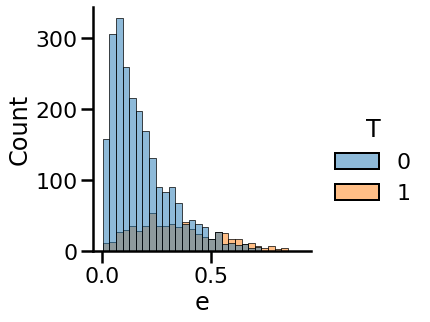

In [ ]:
covariates = ['z{}'.format(i) for i in range(1, 5)]

clf = LogisticRegression(random_state=10, solver='lbfgs').\
            fit(data_sim[covariates], data_sim['T'])

data_sim = data_sim.assign(e=clf.predict_proba(data_sim[covariates])[:, 1])
sns.displot(data_sim, x='e', hue='T', kind='hist')

In [ ]:
data_sim = data_sim.assign(wt=np.nan)
data_sim.loc[data_sim['T']==0, 'wt'] = 1 / (1-data_sim.loc[data_sim['T']==0, 'e'])
data_sim.loc[data_sim['T']==1, 'wt'] = 1 / (data_sim.loc[data_sim['T']==1, 'e'])

ate_ipw = np.mean(data_sim.wt * data_sim.Y * data_sim['T'] -
                    data_sim.wt * data_sim.Y * (1-data_sim['T']))
print(ate_ipw)

9.477570711806395


In [ ]:
N_boot=1000
ate_ipw_boot = np.empty(N_boot)
for i in range(N_boot):
    idx_boot = rg.choice(n, n, replace=True)
    sim_boot = data_sim.loc[idx_boot]
    # Fit the propensity score model on the bootstrapped data
    clf = LogisticRegression(random_state=10).\
            fit(sim_boot[covariates], sim_boot['T'])
    sim_boot = sim_boot.assign(e=clf.predict_proba(sim_boot[covariates])[:, 1])
    sim_boot = sim_boot.assign(wt=np.nan)
    sim_boot.loc[sim_boot['T']==0, 'wt'] = 1 / (1-sim_boot.loc[sim_boot['T']==0, 'e'])
    sim_boot.loc[sim_boot['T']==1, 'wt'] = 1 / (sim_boot.loc[sim_boot['T']==1, 'e'])

    point_wtd = np.mean(sim_boot.wt * sim_boot.Y * sim_boot['T'] -
                        sim_boot.wt * sim_boot.Y * (1-sim_boot['T']))
    ate_ipw_boot[i] = point_wtd

In [ ]:
print([ate_ipw - sps.norm.ppf(0.975) * np.std(ate_ipw_boot),
       ate_ipw + sps.norm.ppf(0.975) * np.std(ate_ipw_boot)])

[-5.37554269281709, 24.33068411642988]


The result is surprising, however the IPW estimator can have a high variance due to propensity scores too close to 1 or 0.

### question 2: Let's compare matching and IPW on a the real dataset we just saw during the lecture

In [ ]:
# let's get the data
nsw_data = pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/nsw_mixtape.dta")


In [ ]:
# basic ATE
mean1 = nsw_data[nsw_data.treat==1].re78.mean()
mean0 = nsw_data[nsw_data.treat==0].re78.mean()
ate = mean1 - mean0
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.34


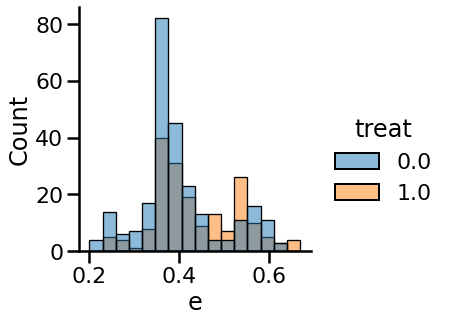

In [ ]:
covariates = ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75']
sc_covariates = ['sc_{}'.format(cov) for cov in covariates]

clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=10, solver='lbfgs'))
clf.fit(nsw_data[covariates], nsw_data.treat)
            

nsw_data = nsw_data.assign(e=clf.predict_proba(nsw_data[covariates])[:, 1])
sns.displot(nsw_data, x='e', hue='treat', kind='hist')

In [ ]:
nsw_data = nsw_data.assign(wt=np.nan)
nsw_data.loc[nsw_data.treat==0, 'wt'] = 1 / (1-nsw_data.loc[nsw_data.treat==0, 'e'])
nsw_data.loc[nsw_data.treat==1, 'wt'] = 1 / (nsw_data.loc[nsw_data.treat==1, 'e'])

ate_ipw = np.mean(nsw_data.wt * nsw_data.re78 * nsw_data.treat -
                    nsw_data.wt * nsw_data.re78 * (1-nsw_data.treat))
print(ate_ipw)

1610.5248404488543


In [ ]:
# let's bootstrap
N = nsw_data.shape[0]
N_boot=1000
ate_ipw_boot = np.empty(N_boot)
for i in range(N_boot):
    idx_boot = rg.choice(N, N, replace=True)
    nsw_boot = nsw_data.loc[idx_boot]
    # Fit the propensity score model on the bootstrapped data
    clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=10, solver='lbfgs')).\
            fit(nsw_boot[covariates], nsw_boot['treat'])
    nsw_boot = nsw_boot.assign(e=clf.predict_proba(nsw_boot[covariates])[:, 1])
    nsw_boot = nsw_boot.assign(wt=np.nan)
    nsw_boot.loc[nsw_boot['treat']==0, 'wt'] = 1 / (1-nsw_boot.loc[nsw_boot['treat']==0, 'e'])
    nsw_boot.loc[nsw_boot['treat']==1, 'wt'] = 1 / (nsw_boot.loc[nsw_boot['treat']==1, 'e'])

    point_wtd = np.mean(nsw_boot.wt * nsw_boot.re78 * nsw_boot['treat'] -
                        nsw_boot.wt * nsw_boot.re78 * (1-nsw_boot['treat']))
    ate_ipw_boot[i] = point_wtd

In [ ]:
print([ate_ipw - sps.norm.ppf(0.975) * np.std(ate_ipw_boot),
       ate_ipw + sps.norm.ppf(0.975) * np.std(ate_ipw_boot)])

[216.6687338188176, 3004.380947078891]


In [ ]:
cm = CausalModel(
    Y=nsw_data.re78.values,
    D=nsw_data['treat'].values ,
    X=nsw_data[covariates].values)
cm.est_via_matching(weights='maha', bias_adj=True)
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1864.464    976.203      1.910      0.056    -48.894   3777.823
           ATC   1589.776   1129.696      1.407      0.159   -624.427   3803.979
           ATT   2250.513   1063.731      2.116      0.034    165.599   4335.426



/usr/local/lib/python3.7/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
